### Modelo de Clasificación: **Árbol de Decision**

Los árboles de decisión son modelos predictivos formados por reglas binarias (si/no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

In [27]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,f1_score ,precision_score, recall_score

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scipy.stats import uniform, poisson

In [28]:
# Leemos el dataset
df_diabetes = pd.read_csv("diabetes.csv",encoding="ISO-8859-1",delimiter=",")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Dividir los datos en variables dependientes e independientes

In [29]:
# Separamos en atributos y clase
X1 = df_diabetes.drop(['Outcome'], axis=1)

y1 = df_diabetes['Outcome']

### Dividir los datos en Train y Test

In [30]:
# Utilizamos train_test_split e indicamos que el tamaño del set de testeo sea del 20%
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

# Modelo 1: Primer acercamiento

---

1. Crear árbol de decisión sin ningún parámetro
2. Evaluar el modelo
3. Graficar

In [31]:
# Creamos el árbol de decisión 
clf = DecisionTreeClassifier()
clf = clf.fit(X1_train, y1_train)

In [32]:
# Realizamos la predicción
predictions = clf.predict(X1_test)

### Evaluación del modelo

#### Matriz de confusión
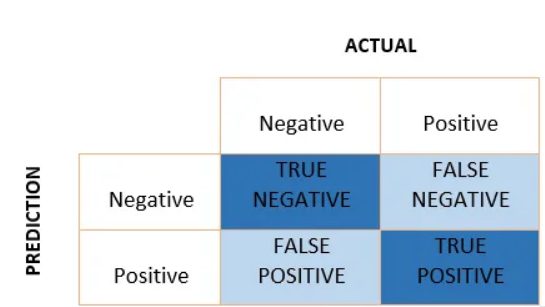

**True Positive (TP)**: El modelo predice correctamente la clase positiva (tanto la predicción como el valor real son positivos). 

**True Negative (TN)**: El modelo predice correctamente la clase negativa (tanto la predicción como el valor real son negativos). 

**False Positive (FP)**: El modelo da una predicción incorrecta de la clase negativa (predice como positivo, pero el valor real es negativo). FP también se llama **error de Tipo I**.

**False Negative (FN)**: El modelo predice incorrectamente la clase positiva (predice como negativo, pero el valor real es positivo). FN también se llama **error de Tipo II**.

### Métricas

| Métricas | Definición | Fórmula |
| -------- | ---------- | ------- |
| accuracy_score | Mide la proporción de predicciones correctas en relación con el número total de predicciones |  $$TP + TN \ \over TP+TN+FP+FN$$ |
| precision_score| De todas las predicciones positivas, ¿qué proporción es realmente positiva?. | $$TP \ \over TP+FP$$|
| recall_score: | De todos los casos positivos, ¿qué porcentaje se predice como positivo? | $$TP \ \over TP+FN$$|
| f1_score:| Combina la precisión y la sensibilidad en un solo número. Es especialmente útil cuando tenemos un desequilibrio entre las clases| $$ 2 * (Precisión * Sensibilidad) \ \over (Precisión + Sensibilidad) $$|


In [33]:
# Evaluación del modelo
print('Accuracy:',round(accuracy_score(y1_test, predictions), 2))
print('Precisión:',round(precision_score(y1_test, predictions),2))
print('Recall score:',round(recall_score(y1_test, predictions),2))
print('F1 score:',round(f1_score(y1_test, predictions),2))

Accuracy: 0.73
Precisión: 0.66
Recall score: 0.63
F1 score: 0.64


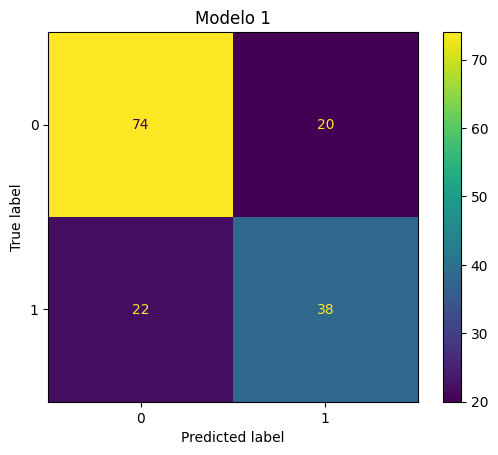

In [34]:
# Matriz de confusión
cm = confusion_matrix(y1_test, predictions, labels=[0,1])
ConfusionMatrixDisplay(cm).plot()
plt.title('Modelo 1')
plt.show()

In [35]:
# Reporte de la clasificación
print('Reporte de clasificación:\n',classification_report(y1_test, predictions, target_names=['No', 'Si']))

Reporte de clasificación:
               precision    recall  f1-score   support

          No       0.77      0.79      0.78        94
          Si       0.66      0.63      0.64        60

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



**Conclusiones del primer modelo**

La exactitud del modelo es moderada (68%). Sin embargo, el recall que es una métrica de gran interes en este caso particular (por ser porcentaje de casos positivos que fueron predichos correctamente) es solo del 47%.

El reporte de clasificación muestra un desbalance en el rendimiento del modelo entre las dos clases ("No" y "Si"). El modelo tiene un mejor rendimiento en la clase "No" en comparación con la clase "Si". Esto puede deberse a un desequilibrio en la distribución de las clases en el conjunto de datos.

### Gráfico

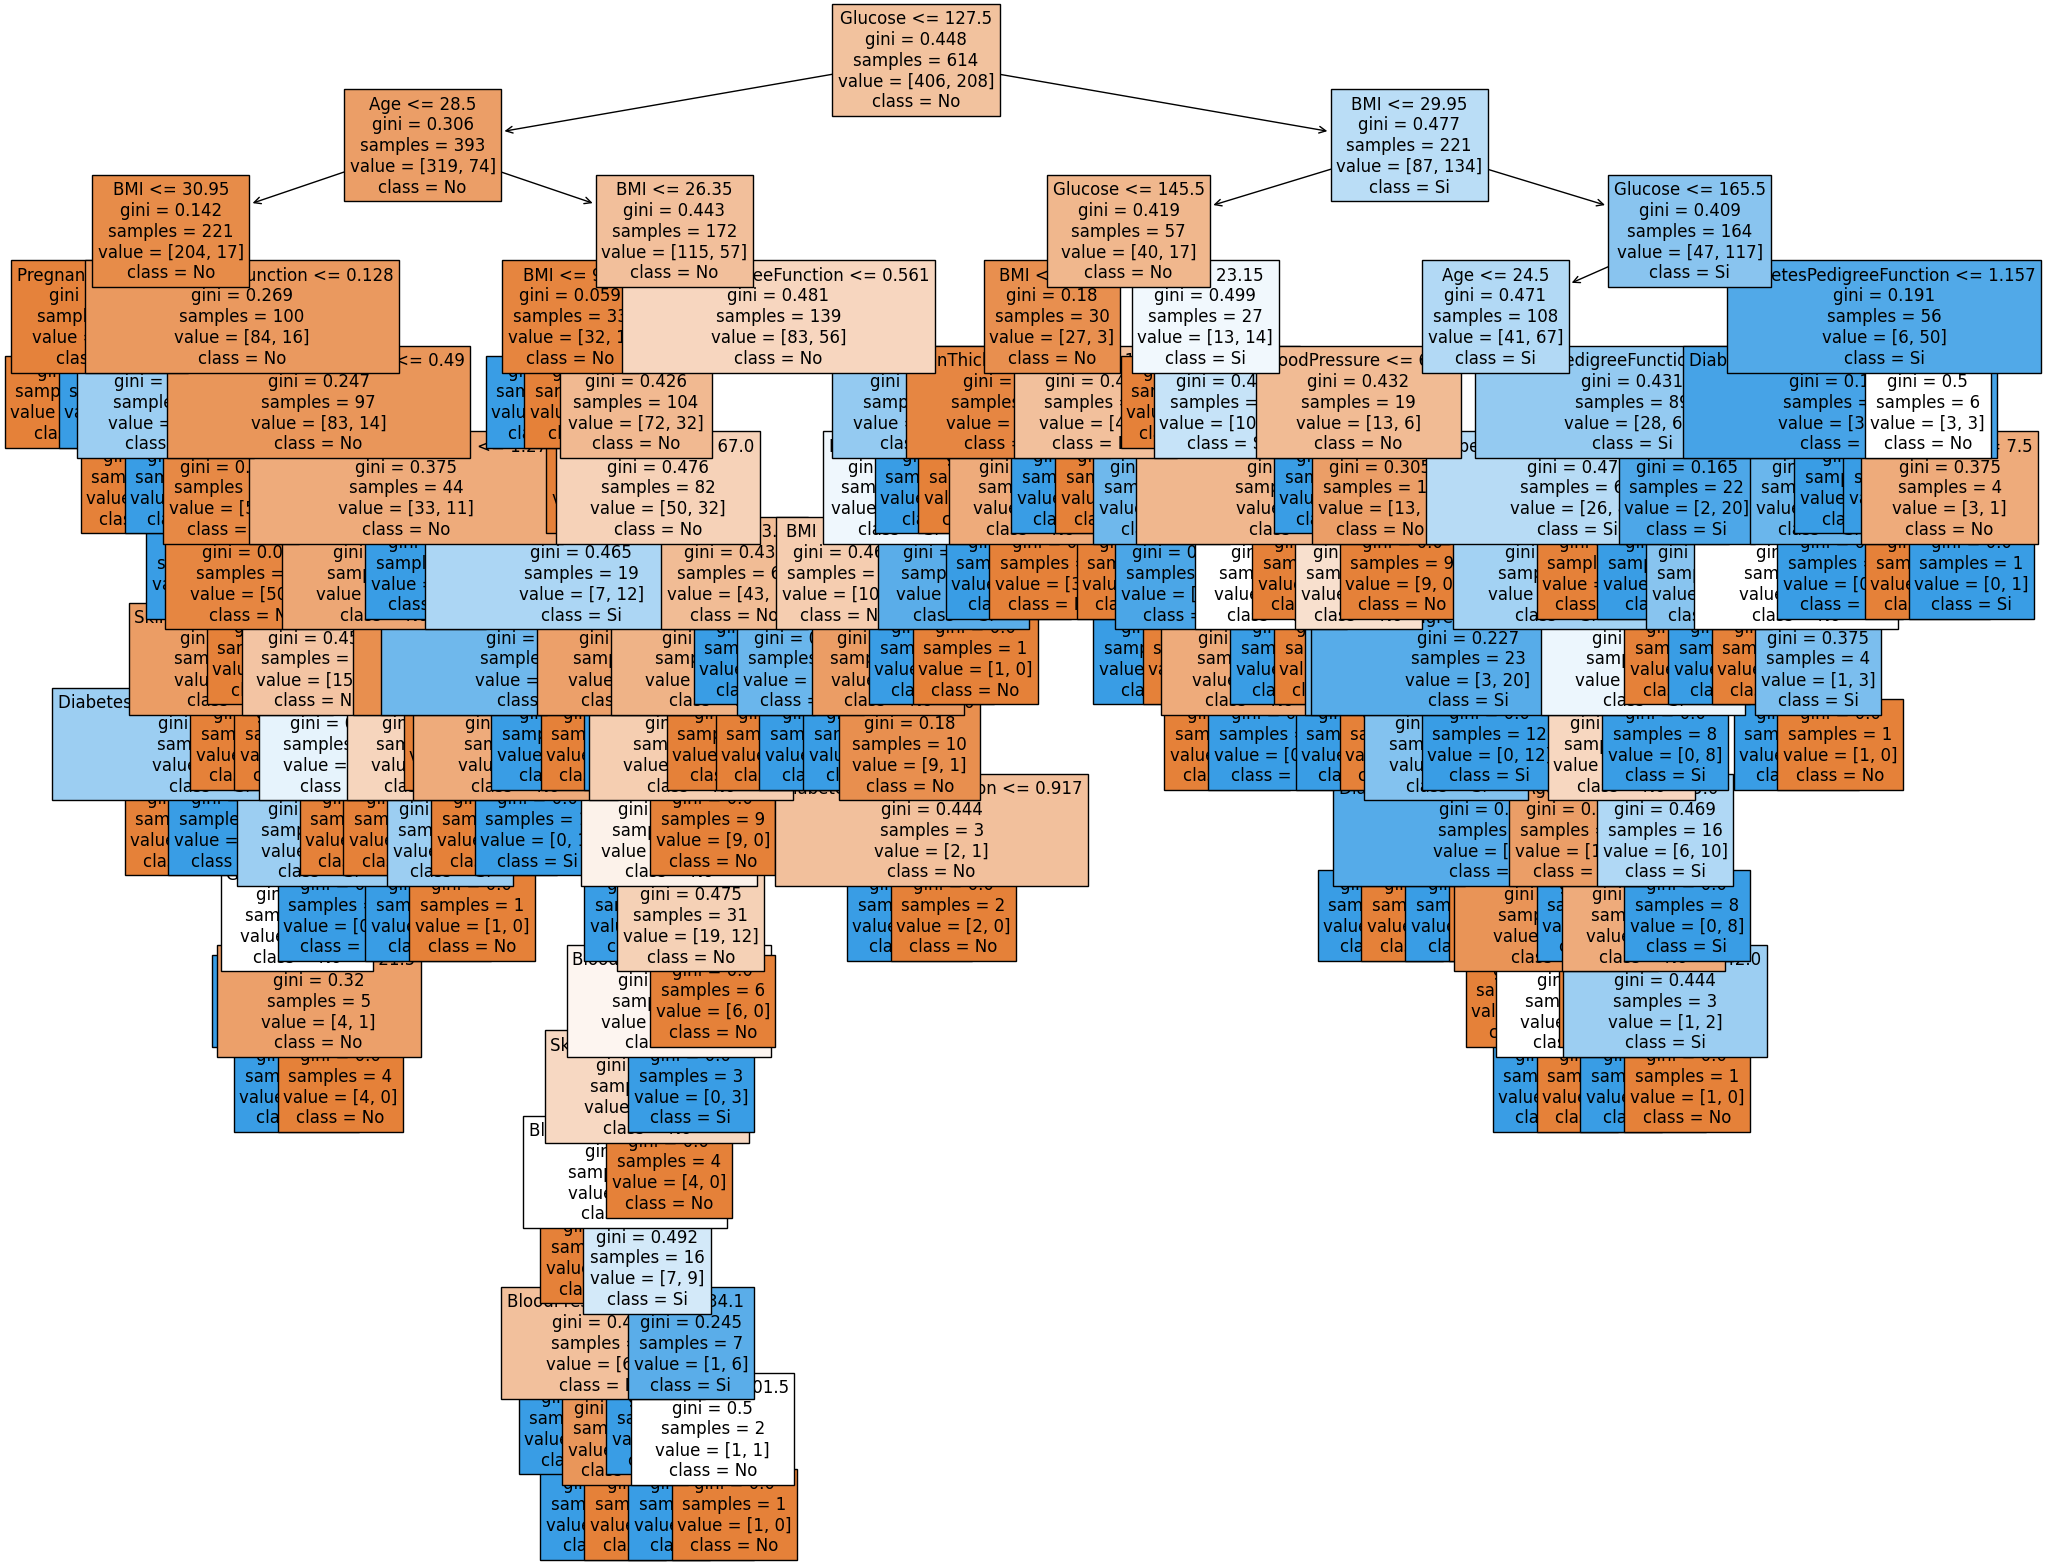

In [10]:
# Obtenemos los nombres de las features (atributos)
feature_names = X1.columns

# Graficamos el árbol
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                  feature_names=feature_names,
                  class_names={0:'No', 1:'Si'},
                  filled=True,
                  fontsize=12)

**Conclusiones a partir del gráfico**

Al no tener parámetros el árbol puede extenderse indefinidamente o hasta que la probabilidad de la clase sea 1, es decir, hasta que la pureza de las hojas sea completa.
Esta falta de restricciones en la profundidad puede llevar a un sobreajuste (overfitting) del modelo a los datos de entrenamiento.
Para evitar esto, en el siguiente modelo, vamos a restringir el max_depth

# Modelo 2: Primeros ajustes

---

1. Trabajar valores faltantes (preprocesamiento)
2. Crear árbol con restricciones de profundidad (arbitriariamente)

In [94]:
df_diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


**PREPROCESAMIENTO DE LOS DATOS**

In [36]:
# Agrupa por la etiqueta y calcula la mediana para cada columna
medians = df_diabetes.groupby('Outcome')[["Glucose", "BMI", "BloodPressure", "SkinThickness"]].median()

# Itera a través de las columnas de interés
for col in ["Glucose", "BMI", "BloodPressure", "SkinThickness"]:
    # Reemplaza los valores iguales a 0 por las medianas correspondientes
    df_diabetes.loc[(df_diabetes[col] == 0) & (df_diabetes['Outcome'] == 0), col] = medians.loc[0, col]
    df_diabetes.loc[(df_diabetes[col] == 0) & (df_diabetes['Outcome'] == 1), col] = medians.loc[1, col]

In [12]:
medians

,Glucose,BMI,BloodPressure,SkinThickness
Outcome,,,,
0,107.0,30.05,70.0,21.0
1,140.0,34.25,74.0,27.0


In [37]:
# Filtra las filas donde 'Insulin' no sea igual a cero y agrupa por 'Outcome'
filtered_data = df_diabetes[df_diabetes['Insulin'] != 0]

medians2 = filtered_data.groupby('Outcome')['Insulin'].median()

print("Mediana de Insulin para Outcome 0:", medians2.loc[0])
print("Mediana de Insulin para Outcome 1:", medians2.loc[1])
print()
print(medians2)

Mediana de Insulin para Outcome 0: 102.5
Mediana de Insulin para Outcome 1: 169.5

Outcome
0    102.5
1    169.5
Name: Insulin, dtype: float64


In [38]:
# Define una función que reemplace los ceros en 'Insulin' por la mediana correspondiente
def replace_insulin(row):
    if row['Insulin'] == 0:
        return medians2[row['Outcome']]
    else:
        return row['Insulin']

# Aplica la función a cada fila del DataFrame
df_diabetes['Insulin'] = df_diabetes.apply(replace_insulin, axis=1)

In [39]:
conteo_de_ceros = (df_diabetes.iloc[:, :-1] == 0).sum()

print(conteo_de_ceros)

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [40]:
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,169.5,33.6,0.627,50,1
1,1,85,66,29,102.5,26.6,0.351,31,0
2,8,183,64,27,169.5,23.3,0.672,32,1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,1


In [41]:
# Separamos en atributos y clases
X2 = df_diabetes.iloc[:,:-1]
y2 = df_diabetes['Outcome']

# Dividimos los datos 
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, shuffle=True, test_size=0.2, random_state=42)

# Creamos el árbol de decisión (sin parámetros)
clf2 = DecisionTreeClassifier(max_depth=5)
clf2 = clf2.fit(X2_train, y2_train)

# Realizamos la predicción
predictions2 = clf2.predict(X2_test)

### Evaluamos el modelo 2

In [42]:
# Evaluación del modelo 2
print('Accuracy:',round(accuracy_score(y2_test, predictions2), 2))
print('Precisión:',round(precision_score(y2_test, predictions2),2))
print('Recall score:',round(recall_score(y2_test, predictions2),2))
print('F1 score:',round(f1_score(y2_test, predictions2),2))

Accuracy: 0.84
Precisión: 0.83
Recall score: 0.71
F1 score: 0.76


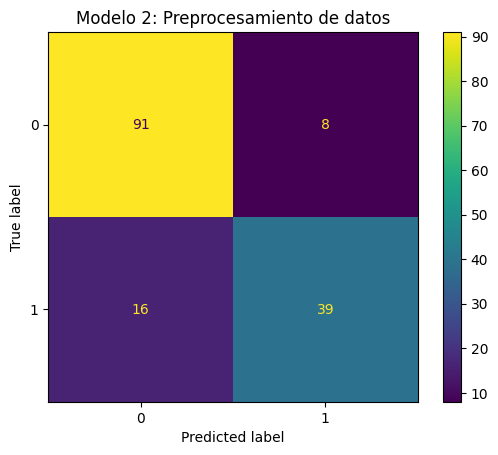

In [43]:
# Matriz de confusión
cm2 = confusion_matrix(y2_test, predictions2, labels=[0,1])
ConfusionMatrixDisplay(cm2).plot()
plt.title('Modelo 2: Preprocesamiento de datos')
plt.show()

In [44]:
# Reporte de la clasificación 2
print('Reporte de clasificación:\n',classification_report(y2_test, predictions2, target_names=['No', 'Si']))

Reporte de clasificación:
               precision    recall  f1-score   support

          No       0.85      0.92      0.88        99
          Si       0.83      0.71      0.76        55

    accuracy                           0.84       154
   macro avg       0.84      0.81      0.82       154
weighted avg       0.84      0.84      0.84       154



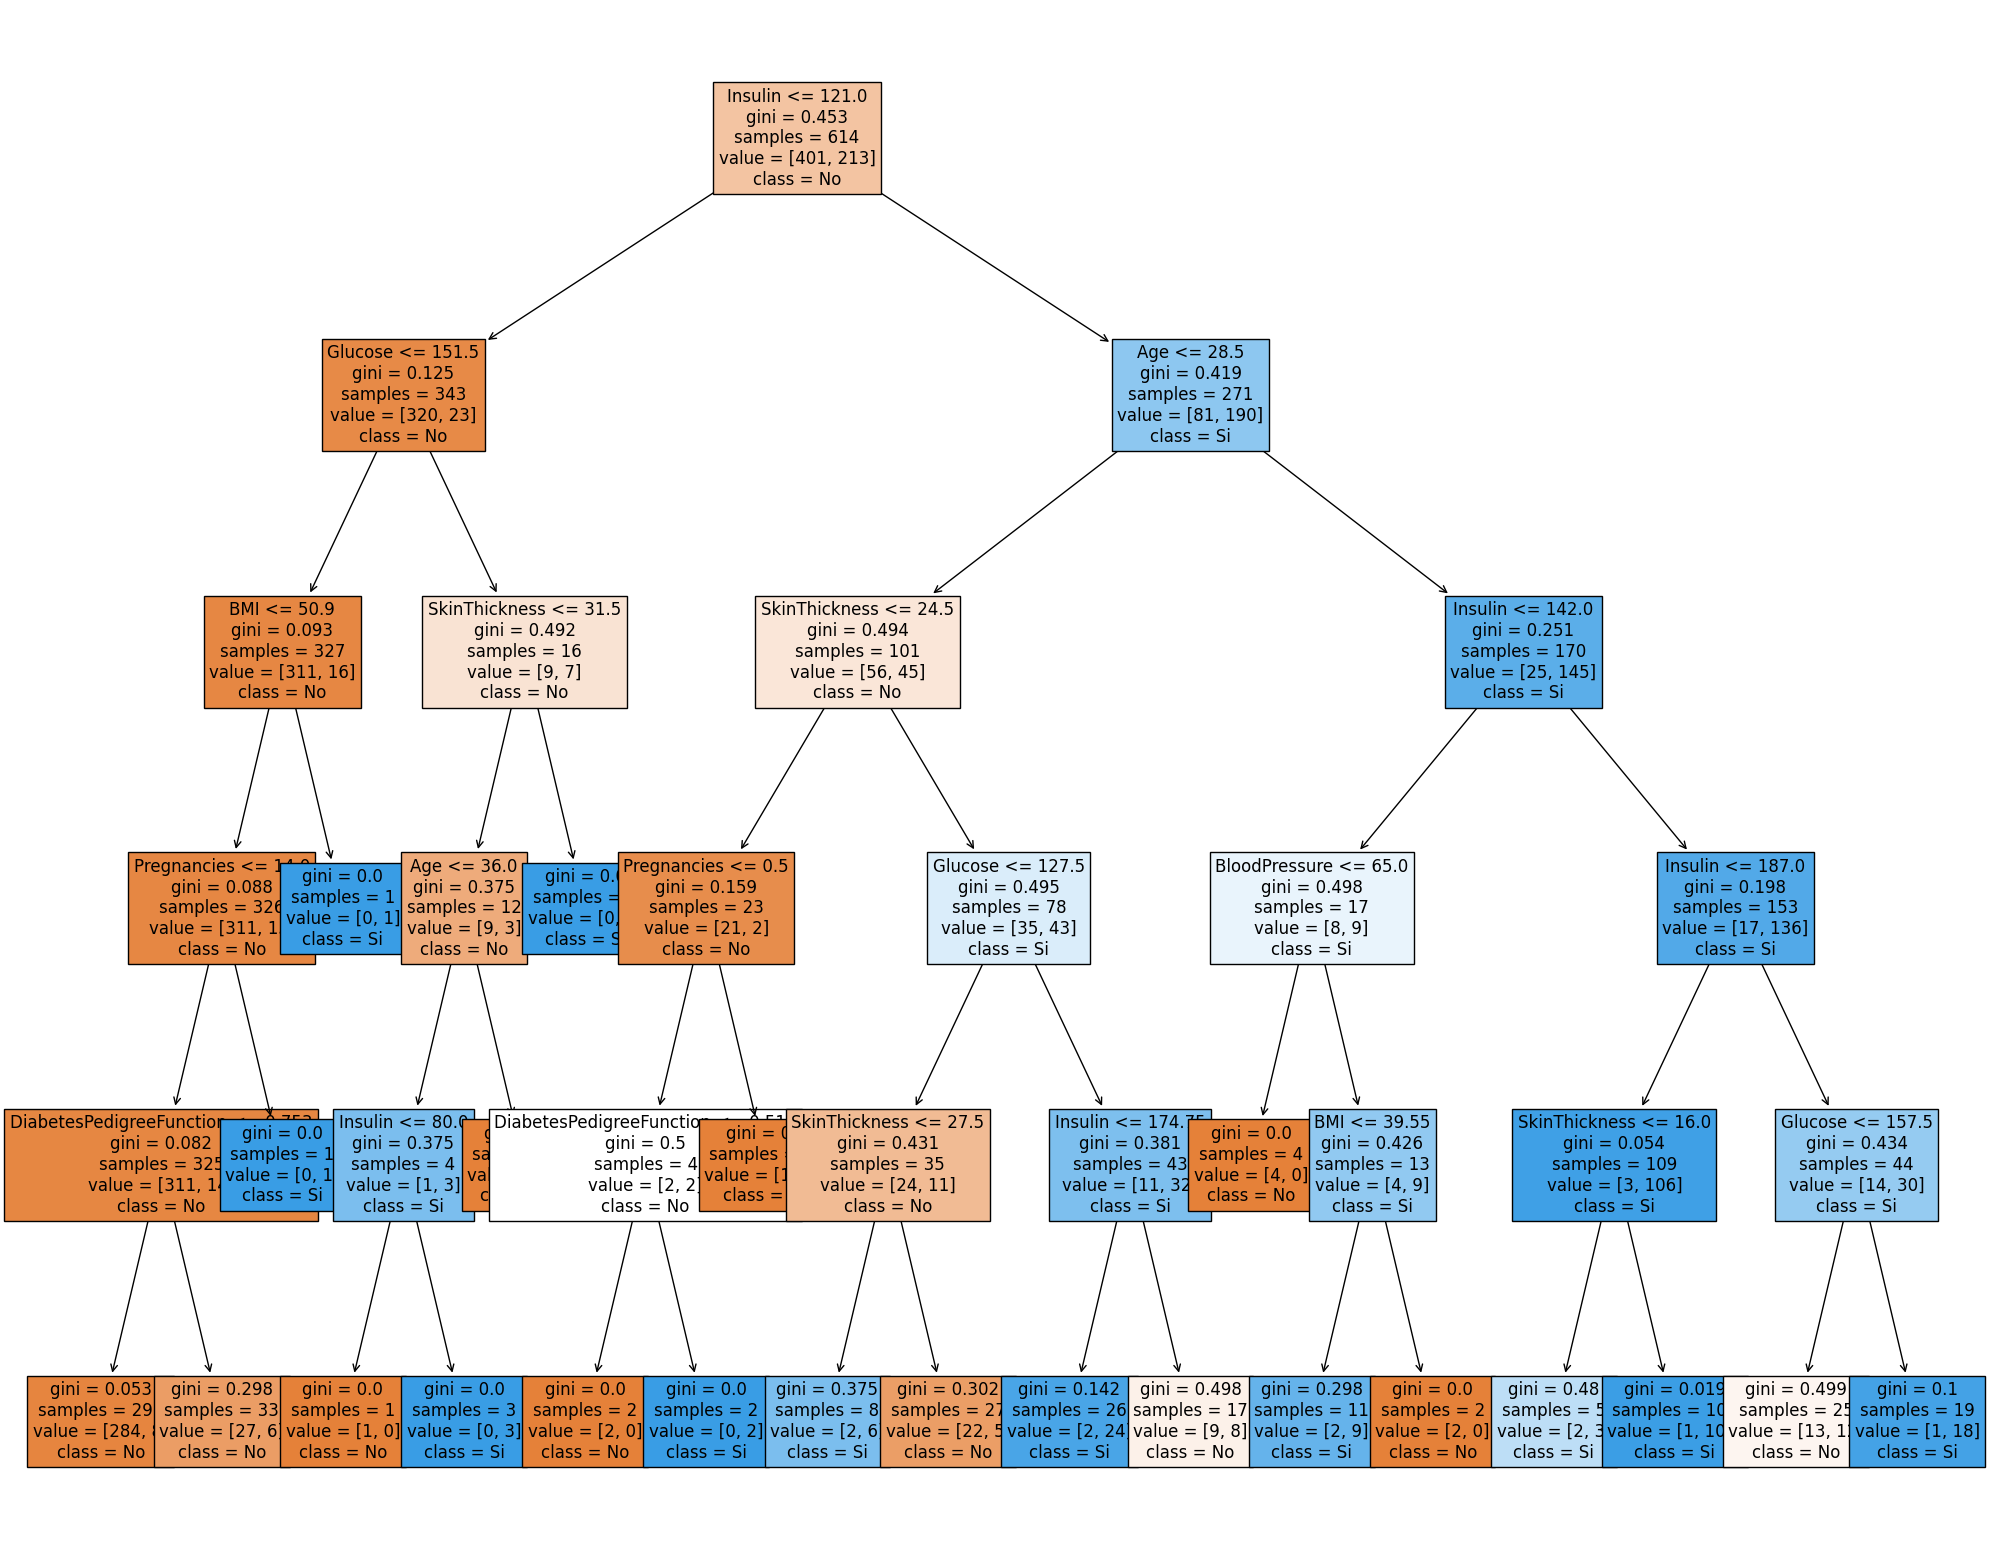

In [21]:
# Graficamos el árbol
fig = plt.figure(figsize=(25,20))
arbol2 = tree.plot_tree(clf2,
                  feature_names=feature_names,
                  class_names={0:'No', 1:'Si'},
                  filled=True,
                  fontsize=12)

**Conclusiones Modelo 2**

Podemos observar que el segundo modelo, con los ajustes realizados, tiene un mejor rendimiento que el anterior. La exactitud subió a un 84%. 

Se observa que tiene un mejor rendimiento a la hora de predecir la clase No

Especificando el max_depth, podemos observas cómo se simplificó el árbol.

**Siguientes pasos para mejorar el modelo**

---

1. Optimización de hiperparámetros

## Optimización de hiperparámetros

Los árboles de decisión, como la mayoría de los algoritmos de aprendizaje automático, tienen dos tipos de parámetros: los que se pueden aprender durante el entrenamiento y los que no se pueden aprender. Los parámetros aprendibles se calculan durante el entrenamiento y permiten al modelo aprender los valores óptimos por sí mismo. Por otro lado, los parámetros no aprendibles se deben establecer antes del proceso de entrenamiento y a menudo definen la estructura específica del modelo, como la profundidad máxima del árbol o el número mínimo de muestras requeridas para dividir un nodo. Estos parámetros no aprendibles se llaman **hiperparámetros** y los aprendibles se denominan parámetros o pesos.

Algunos de los hiperparámetros más comunes son la elección de la función de pérdida para dividir un nodo, la profundidad máxima del árbol, el número mínimo de muestras requeridas para dividir un nodo y el número máximo de nodos hoja. Optimizar estos hiperparámetros para una tarea específica suele mejorar el rendimiento del modelo, lo que significa que el árbol de decisión podrá hacer mejores predicciones en datos no vistos y evitar el sobreajuste durante el entrenamiento.

#### Bayes Search CV

In [ ]:
%pip install scikit-optimize

In [45]:
# Dividir en atributos y clases
X3 = df_diabetes.iloc[:,:-1]
y3 = df_diabetes['Outcome']

# Dividir los datos de entrenamiento y testeo
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, stratify=y3, random_state=42)

*Se agregó el parámetro stratify que asegura que la proporción de clases (clase positiva y clase negativa) en los conjuntos de entrenamiento y prueba sea la misma que la proporción en el conjunto de datos original. Esto es importante para evitar posibles sesgos en la división de los datos y garantizar que el modelo se entrene y se pruebe de manera justa en ambas clases.

Para realizar la optimización con Bayes Search, debemos crear el espacio para los parámetros

In [46]:
# Definir el espacio de parámetros
parameters = {'criterion': Categorical(['gini','entropy']),
              'max_depth': Integer(1,21,prior='log-uniform'), #
              'min_samples_split': Real(1e-3,1.0,prior='log-uniform'),
              'max_leaf_nodes': Integer(3,26,prior='uniform')}

In [47]:
# Instaciamos un objeto de Bayes Search pasandole el espacio de parámetros
b1 = BayesSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_iter=10, random_state=42, n_jobs=-1)

# Realizamos una búsqueda sobre el espacio de parámetros
start_time = time.time()
b1.fit(X3_train, y3_train)
duration = time.time() - start_time

# Mostramos la mejor configuración de parámetros obtenida
cls_params = b1.best_params_
cls_params['min_samples_split'] = np.ceil(cls_params['min_samples_split']*X3_train.shape[0])
cls_params

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 12),
             ('max_leaf_nodes', 20),
             ('min_samples_split', 4.0)])

In [48]:
# Crear el árbol con los parámetros obtenidos
clf3 = b1.best_estimator_

# Realizar la predicción
predictions3 = clf3.predict(X3_test)

#### Evaluación del modelo con la optimización de Bayes

In [49]:
# Evaluación del modelo 3
print('Accuracy:',round(accuracy_score(y3_test, predictions3), 2))
print('Precisión:',round(precision_score(y3_test, predictions3),2))
print('Recall score:',round(recall_score(y3_test, predictions3),2))
print('F1 score:',round(f1_score(y3_test, predictions3),2))

Accuracy: 0.88
Precisión: 0.86
Recall score: 0.8
F1 score: 0.83


In [50]:
# Reporte de la clasificación 3
print('Reporte de clasificación:\n',classification_report(y3_test, predictions3, target_names=['No', 'Si']))

Reporte de clasificación:
               precision    recall  f1-score   support

          No       0.89      0.93      0.91       100
          Si       0.86      0.80      0.83        54

    accuracy                           0.88       154
   macro avg       0.88      0.86      0.87       154
weighted avg       0.88      0.88      0.88       154



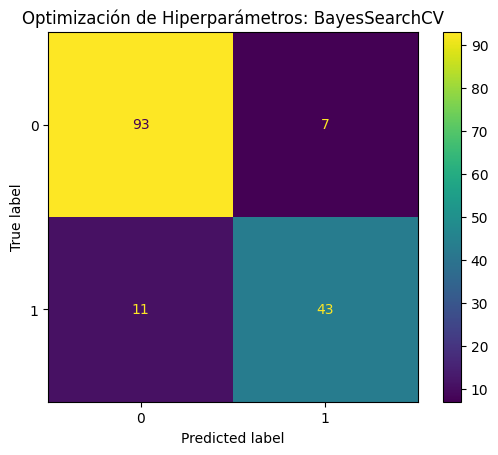

In [51]:
# Matriz de confusión
cm2 = confusion_matrix(y3_test, predictions3, labels=[0,1])
ConfusionMatrixDisplay(cm2).plot()
plt.title('Optimización de Hiperparámetros: BayesSearchCV')
plt.show()

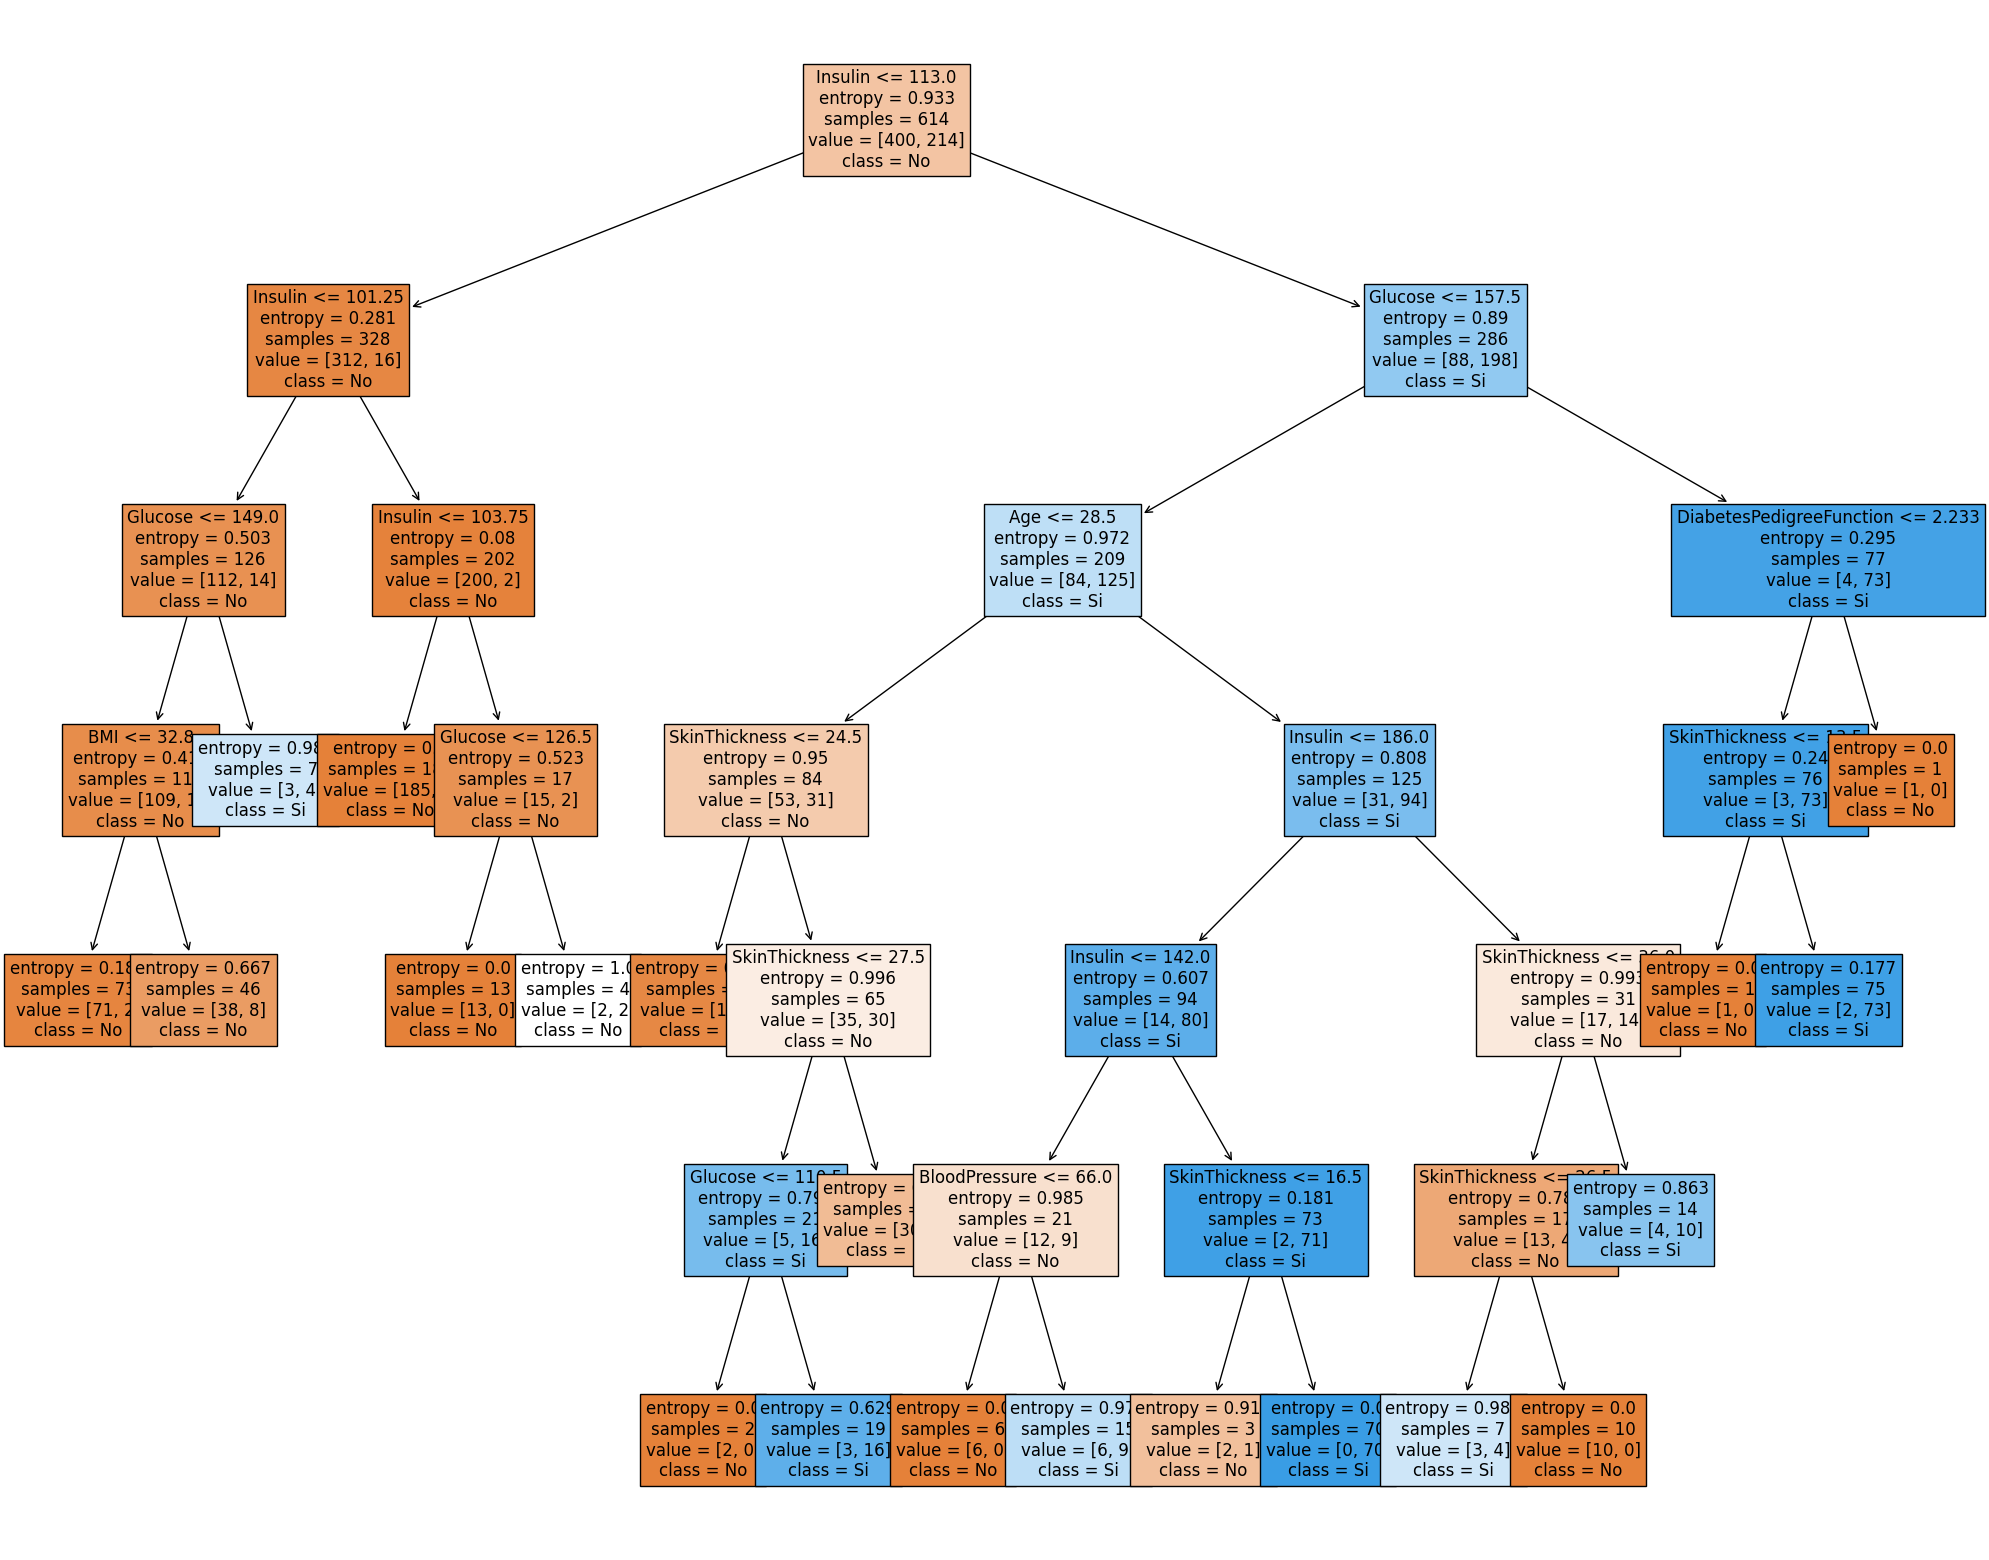

In [52]:
# Obtenemos los nombres de las features (atributos)
feature_names = X3.columns

# Graficamos el árbol
fig = plt.figure(figsize=(25,20))
arbol3 = tree.plot_tree(clf3,
                  feature_names=feature_names,
                  class_names={0:'No', 1:'Si'},
                  filled=True,
                  fontsize=12)